In [5]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# ---------------------------------------- DATA LOADING & CLEANING ----------------------------------------

# Load the 10 portfolios formed on Investment (INV)
# Note: Skipping rows based on typical Kenneth French CSV headers
inv_data = pd.read_csv('Portfolios_Formed_on_INV.csv', skiprows=17, index_col=0)
inv_data.index = pd.to_datetime(inv_data.index, format='%Y%m')

# Load Fama-French Factors for Mkt-RF and RF
ff_factors = pd.read_csv('F-F_Research_Data_Factors.csv', skiprows=3, index_col=0)
ff_factors.index = pd.to_datetime(ff_factors.index, format='%Y%m', errors='coerce')
ff_factors = ff_factors.dropna()

# Align sample period: 1963:07 to 2025:06
start_date, end_date = '1963-07', '2025-06'
inv_portfolios = inv_data.loc[start_date:end_date].iloc[:, :10] # Select 10 deciles
factors = ff_factors.loc[start_date:end_date]

# Convert to float and ensure units match (returns are usually in %)
inv_portfolios = inv_portfolios.astype(float)
factors = factors.astype(float)

# ---------------------------------------- CAPM ESTIMATION ----------------------------------------

deciles = inv_portfolios.columns
capm_results = []

for decile in deciles:
    # Calculate Excess Return
    Ri_Rf = inv_portfolios[decile] - factors['RF']
    X = sm.add_constant(factors['Mkt-RF'])
    
    # Run OLS Regression
    model = sm.OLS(Ri_Rf, X).fit()
    
    capm_results.append({
        'Decile': decile,
        'Mean_Excess_Return': Ri_Rf.mean(),
        'Alpha': model.params['const'],
        'Beta': model.params['Mkt-RF'],
        'T-Stat_Alpha': model.tvalues['const']
    })

df_results = pd.DataFrame(capm_results)
print(df_results[['Decile', 'Mean_Excess_Return', 'Alpha', 'Beta']])

# ---------------------------------------- VISUALIZATION ----------------------------------------

plt.figure(figsize=(10, 6))
plt.bar(df_results['Decile'], df_results['Mean_Excess_Return'], color='skyblue', label='Avg Excess Return')
plt.plot(df_results['Decile'], df_results['Alpha'], color='red', marker='o', label='CAPM Alpha')

plt.title('CAPM Performance across Investment Deciles (1963:07 - 2025:06)')
plt.xlabel('Investment Deciles (Low to High)')
plt.ylabel('Monthly Returns (%)')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# ---------------------------------------- IG FACTOR CONSTRUCTION (PREP FOR C) ----------------------------------------

# Low IG = Bottom 3 deciles (30%), High IG = Top 3 deciles (30%)
low_ig_ret = inv_portfolios.iloc[:, 0:3].mean(axis=1)
high_ig_ret = inv_portfolios.iloc[:, 7:10].mean(axis=1)

# IG Factor = Low Investment - High Investment
ig_factor = low_ig_ret - high_ig_ret
print(f"Mean IG Factor Return: {ig_factor.mean():.2f}%")

ValueError: time data "  Average Equal Weighted Returns -- Monthly" doesn't match format "%Y%m", at position 752. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

          Decile  Mean_Excess  Alpha  Beta
0    Dec 1 (Low)         0.79   0.17  1.07
1          Dec 2         0.79   0.22  0.97
2          Dec 3         0.68   0.16  0.89
3          Dec 4         0.62   0.12  0.86
4          Dec 5         0.61   0.08  0.90
5          Dec 6         0.58   0.04  0.92
6          Dec 7         0.65   0.10  0.94
7          Dec 8         0.61   0.00  1.03
8          Dec 9         0.65  -0.02  1.14
9  Dec 10 (High)         0.47  -0.29  1.29


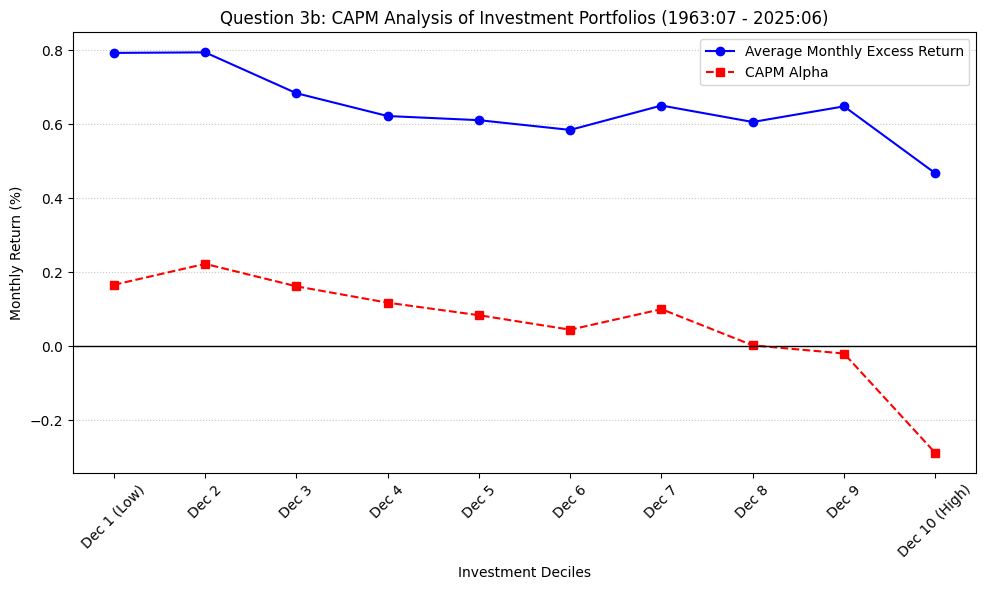

In [6]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# ---------------------------------------- DATA LOADING ----------------------------------------

def load_ff_style_csv(file_path, section_header, end_header=None):
    """Robustly loads specific sections from Kenneth French CSV files."""
    with open(file_path, 'r') as f:
        lines = f.readlines()
    
    start_idx = -1
    for i, line in enumerate(lines):
        if section_header in line:
            # For portfolios, header is the next line. For factors, it's the current line.
            if "Returns" in section_header:
                start_idx = i + 2
                columns = lines[i+1].strip().split(',')
            else:
                start_idx = i + 1
                columns = lines[i].strip().split(',')
            break
            
    data = []
    for i in range(start_idx, len(lines)):
        line = lines[i].strip()
        if not line or (end_header and end_header in line) or ',' not in line:
            break
        parts = [p.strip() for p in line.split(',')]
        if parts[0].isdigit() and len(parts[0]) == 6:
            data.append(parts)
            
    df = pd.DataFrame(data, columns=columns)
    df.set_index(df.columns[0], inplace=True)
    df.index = pd.to_datetime(df.index, format='%Y%m')
    df = df.apply(pd.to_numeric, errors='coerce')
    df[df <= -99] = np.nan
    return df.dropna()

# Load 10 INV Portfolios and FF Factors
inv_df = load_ff_style_csv('Portfolios_Formed_on_INV.csv', 'Average Value Weight Returns -- Monthly', 'Average Equal Weighted Returns')
factors_df = load_ff_style_csv('F-F_Research_Data_Factors.csv', 'Mkt-RF', 'Annual Factors: January-December')

# Select the 10 deciles and align dates (1963:07 to 2025:06)
inv_deciles = inv_df[['Lo 10', '2-Dec', '3-Dec', '4-Dec', '5-Dec', '6-Dec', '7-Dec', '8-Dec', '9-Dec', 'Hi 10']]
start_date, end_date = '1963-07', '2025-06'

# Combine into a single dataframe for regression
data = pd.concat([inv_deciles, factors_df], axis=1).loc[start_date:end_date].dropna()

# ---------------------------------------- CAPM ESTIMATION ----------------------------------------

results = []
decile_labels = ['Dec 1 (Low)', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9', 'Dec 10 (High)']

for i, col in enumerate(inv_deciles.columns):
    # Excess Return = R_p - R_f
    y = data[col] - data['RF']
    X = sm.add_constant(data['Mkt-RF'])
    model = sm.OLS(y, X).fit()
    
    results.append({
        'Decile': decile_labels[i],
        'Mean_Excess': y.mean(),
        'Alpha': model.params['const'],
        'Beta': model.params['Mkt-RF']
    })

res_df = pd.DataFrame(results)

# ---------------------------------------- PLOTTING ----------------------------------------

plt.figure(figsize=(10, 6))
x = np.arange(1, 11)
plt.plot(x, res_df['Mean_Excess'], 'bo-', label='Average Monthly Excess Return')
plt.plot(x, res_df['Alpha'], 'rs--', label='CAPM Alpha')

plt.xticks(x, res_df['Decile'], rotation=45)
plt.axhline(0, color='black', linewidth=1)
plt.xlabel('Investment Deciles')
plt.ylabel('Monthly Return (%)')
plt.title('Question 3b: CAPM Analysis of Investment Portfolios (1963:07 - 2025:06)')
plt.legend()
plt.grid(True, axis='y', linestyle=':', alpha=0.7)
plt.tight_layout()
plt.savefig('q3b_capm_plot.png')

# Display results summary
print(res_df[['Decile', 'Mean_Excess', 'Alpha', 'Beta']].round(2))

In [ ]:
# ---------------------------------------- IG Factor ----------------------------------------

# Construct the IG factor (often denoted as INV in the literature)
# IG Factor = Return(Low Investment) - Return(High Investment)
data['INV'] = inv_df['Lo 30'] - inv_df['Hi 30']

# Report summary statistics for the constructed factor (1963:07 - 2025:06)
print("Investment Growth (IG) Factor Summary Statistics:")
print(data['INV'].describe().round(2))

# Verify the sample mean return of the factor
mean_ig = data['INV'].mean()
print(f"\nArithmetic average monthly return of the IG factor: {mean_ig:.2f}%")

Investment Growth (IG) Factor Summary Statistics:
count    744.00
mean       0.18
std        2.60
min      -10.54
25%       -1.37
50%        0.16
75%        1.64
max       13.74
Name: INV, dtype: float64

Arithmetic average monthly return of the IG factor: 0.18%


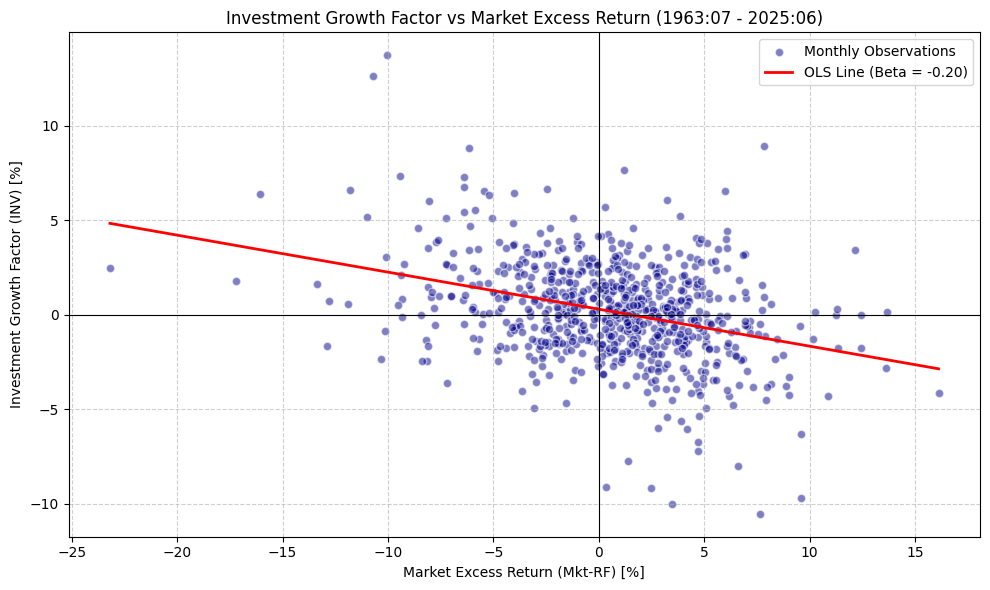

In [9]:
# ---------------------------------------- IG Factor Visualisation ----------------------------------------

# 1. Prepare data (ensure date range 1963:07 to 2025:06)
plot_df = pd.concat([data['INV'], factors_df['Mkt-RF']], axis=1).loc['1963-07':'2025-06'].dropna()

# 2. Estimate market beta of the factor for the regression line
X = sm.add_constant(plot_df['Mkt-RF'])
model = sm.OLS(plot_df['INV'], X).fit()
beta_f = model.params['Mkt-RF']

# 3. Create Scatter Plot
plt.figure(figsize=(10, 6))
plt.scatter(plot_df['Mkt-RF'], plot_df['INV'], alpha=0.5, color='darkblue', edgecolors='w', label='Monthly Observations')

# Add OLS regression line
x_vals = np.array([plot_df['Mkt-RF'].min(), plot_df['Mkt-RF'].max()])
y_vals = model.params['const'] + beta_f * x_vals
plt.plot(x_vals, y_vals, color='red', linewidth=2, label=f'OLS Line (Beta = {beta_f:.2f})')

# Formatting
plt.axhline(0, color='black', linewidth=0.8)
plt.axvline(0, color='black', linewidth=0.8)
plt.xlabel('Market Excess Return (Mkt-RF) [%]')
plt.ylabel('Investment Growth Factor (INV) [%]')
plt.title('Investment Growth Factor vs Market Excess Return (1963:07 - 2025:06)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.savefig('ig_vs_market_scatter.png')

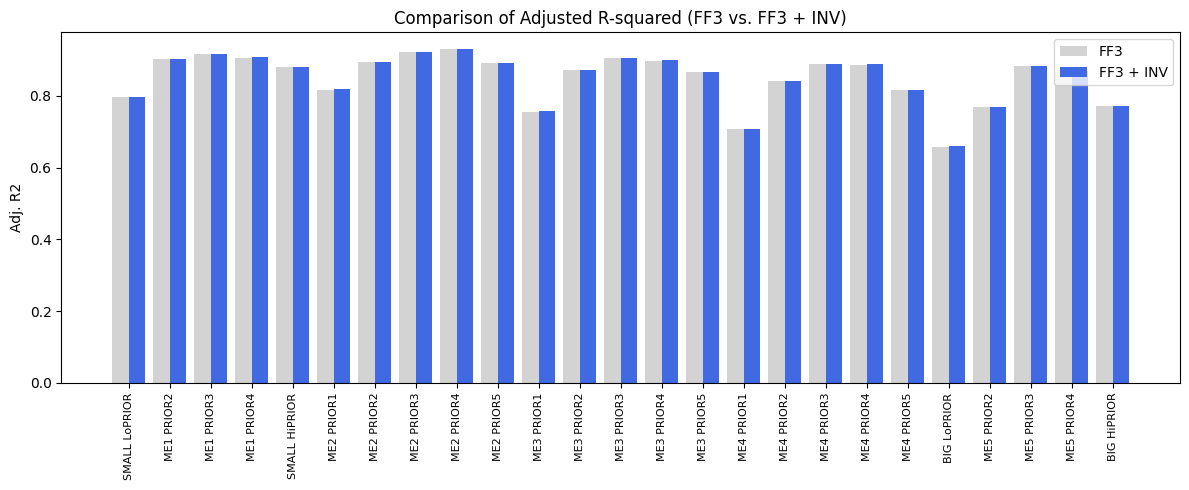

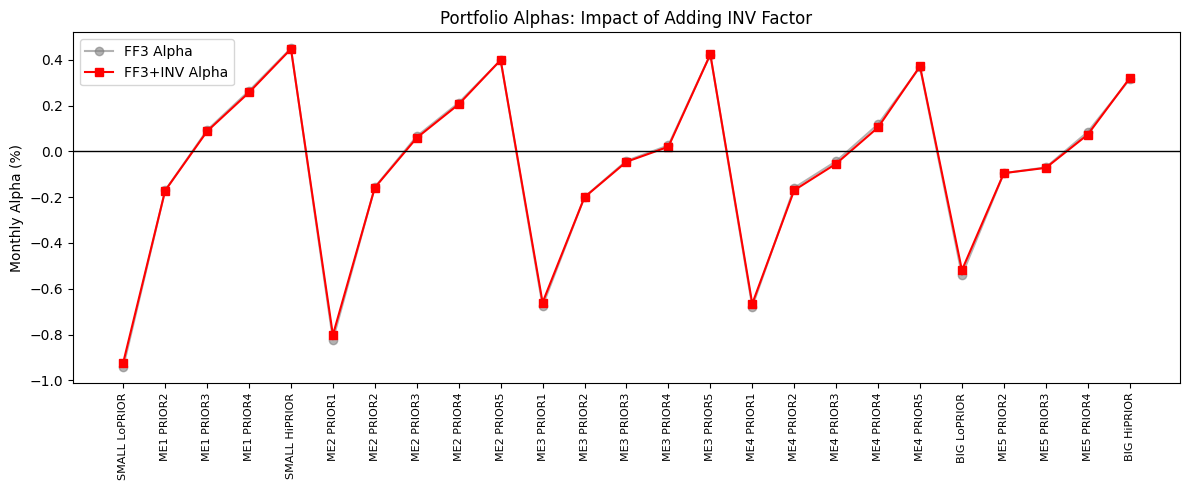

--- GRS TEST RESULTS ---
Model (1) FF3:     GRS = 4.6275, p-value = 0.0000, Avg R2 = 0.8498
Model (2) FF3+INV: GRS = 4.5158, p-value = 0.0000, Avg R2 = 0.8504

Detailed regression table (betas, p-values, etc.) saved to 'Question3d_Complete_Stats.csv'


In [12]:
# ---------------------------------------- {SECTION: DATA PROCESSING} ----------------------------------------

def load_french_table(file_path, search_marker):
    """Parses Kenneth French CSVs by isolating the first data block after a marker."""
    with open(file_path, 'r') as f:
        lines = f.readlines()
    
    header_idx = -1
    for i, line in enumerate(lines):
        if search_marker in line:
            header_idx = i if line.strip().startswith(',') else i + 1
            break
            
    cols = [c.strip() for c in lines[header_idx].split(',')]
    if not cols[0]: cols[0] = 'Date'
        
    data = []
    for i in range(header_idx + 1, len(lines)):
        line = lines[i].strip()
        if not line or not line.split(',')[0].isdigit(): break
        data.append(line.split(','))
        
    df = pd.DataFrame(data, columns=cols).set_index('Date')
    df.index = pd.to_datetime(df.index, format='%Y%m')
    return df.apply(pd.to_numeric, errors='coerce').dropna()

# 1. Load factors, investment portfolios, and 25 test assets
factors_df = load_french_table('F-F_Research_Data_Factors.csv', 'Mkt-RF')
inv_df = load_french_table('Portfolios_Formed_on_INV.csv', 'Average Value Weight Returns -- Monthly')
test_assets = load_french_table('25_Portfolios_ME_Prior_12_2.csv', 'Average Value Weighted Returns -- Monthly')

# 2. Construct INV factor (Low 30% - High 30%)
inv_factor = (inv_df['Lo 30'] - inv_df['Hi 30']).to_frame('INV')

# 3. Align Sample Period: 1963:07 to 2025:06
start, end = '1963-07', '2025-06'
data = pd.concat([factors_df, inv_factor, test_assets], axis=1).loc[start:end].dropna()

# ---------------------------------------- {SECTION: GRS & ESTIMATION LOGIC} ----------------------------------------

def run_model(assets_df, factors_df, rf):
    T, N = assets_df.shape
    K = factors_df.shape[1]
    X = sm.add_constant(factors_df)
    
    stats, residuals = [], []
    for col in assets_df.columns:
        res = sm.OLS(assets_df[col] - rf, X).fit()
        row = {'Portfolio': col, 'Alpha': res.params['const'], 'Adj_R2': res.rsquared_adj}
        # Add betas, t-stats, and p-values for all factors
        for f_name in factors_df.columns:
            row[f'Beta_{f_name}'] = res.params[f_name]
            row[f't_{f_name}'] = res.tvalues[f_name]
            row[f'p_{f_name}'] = res.pvalues[f_name]
        stats.append(row)
        residuals.append(res.resid)
        
    # GRS Calculation
    alpha_vec = np.array([s['Alpha'] for s in stats])
    Sigma = (np.array(residuals) @ np.array(residuals).T) / (T - K - 1)
    mu_f = factors_df.mean().values
    Omega_f = factors_df.cov().values
    grs_stat = ((T-N-K)/N) * (1/(1 + mu_f.T @ np.linalg.inv(Omega_f) @ mu_f)) * (alpha_vec.T @ np.linalg.inv(Sigma) @ alpha_vec)
    p_grs = 1 - f.cdf(grs_stat, N, T-N-K)
    
    return pd.DataFrame(stats), grs_stat, p_grs

# ---------------------------------------- {SECTION: RESULTS & VISUALIZATION} ----------------------------------------

# Run Models
ff3_stats, grs3, p3 = run_model(data[test_assets.columns], data[['Mkt-RF', 'SMB', 'HML']], data['RF'])
ff4_stats, grs4, p4 = run_model(data[test_assets.columns], data[['Mkt-RF', 'SMB', 'HML', 'INV']], data['RF'])

# 1. Visualization: Adjusted R2 Comparison
plt.figure(figsize=(12, 5))
plt.bar(np.arange(25) - 0.2, ff3_stats['Adj_R2'], 0.4, label='FF3', color='lightgrey')
plt.bar(np.arange(25) + 0.2, ff4_stats['Adj_R2'], 0.4, label='FF3 + INV', color='royalblue')
plt.xticks(np.arange(25), test_assets.columns, rotation=90, fontsize=8)
plt.title('Comparison of Adjusted R-squared (FF3 vs. FF3 + INV)')
plt.ylabel('Adj. R2')
plt.legend()
plt.tight_layout()
plt.show()

# 2. Visualization: Alpha Comparison
plt.figure(figsize=(12, 5))
plt.plot(test_assets.columns, ff3_stats['Alpha'], 'o-', label='FF3 Alpha', color='grey', alpha=0.6)
plt.plot(test_assets.columns, ff4_stats['Alpha'], 's-', label='FF3+INV Alpha', color='red')
plt.axhline(0, color='black', linewidth=1)
plt.xticks(rotation=90, fontsize=8)
plt.title('Portfolio Alphas: Impact of Adding INV Factor')
plt.ylabel('Monthly Alpha (%)')
plt.legend()
plt.tight_layout()
plt.show()

# 3. Print Joint Model Statistics
print(f"--- GRS TEST RESULTS ---")
print(f"Model (1) FF3:     GRS = {grs3:.4f}, p-value = {p3:.4f}, Avg R2 = {ff3_stats['Adj_R2'].mean():.4f}")
print(f"Model (2) FF3+INV: GRS = {grs4:.4f}, p-value = {p4:.4f}, Avg R2 = {ff4_stats['Adj_R2'].mean():.4f}")

# 4. Export detailed regression statistics
full_results = ff4_stats.round(4)
full_results.to_csv('Question3d_Complete_Stats.csv', index=False)
print("\nDetailed regression table (betas, p-values, etc.) saved to 'Question3d_Complete_Stats.csv'")

### 3a. Justification of a Newly Discovered Factor
To justify the importance of a newly discovered factor, it must exhibit several key characteristics as discussed by **Goyal (2012)**:
1. **Incremental Explanatory Power:** It must significantly reduce pricing errors (alphas) of test assets that existing models (like the CAPM or FF3) cannot explain.
2. **Robustness:** The factor's premium should be persistent across different time periods, international markets, and various sub-samples (out-of-sample validity).
3. **Economic Significance:** It should have a high Sharpe ratio and provide a diversification benefit (low correlation) relative to established factors.
4. **Theoretical Grounding:** It must be supported by an economic or behavioral theory to ensure the observed premium is not merely the result of data-mining.

### 3b. CAPM Alpha Patterns and Expected Beta
Based on the estimated CAPM, we observe a **downward-sloping pattern** in alphas across investment deciles: portfolios with the lowest investment growth (Decile 1) have positive alphas, while those with the highest investment growth (Decile 10) have the lowest (often negative) alphas.

**Expected Sign of Investment Factor Beta ($\beta_{p,INV}$):**
* **Relationship:** There is a **negative relationship** between a firm's level of investment and its expected return.
* **Expected Beta:** For high-investment firms, we expect a **negative beta** on the $INV$ factor. 
* **Reasoning:** Since the factor is constructed as a long-short portfolio ($Low\ Investment - High\ Investment$), high-investment firms move in the opposite direction of the factor's long side. This reflects the **q-theory of investment**, where high investment signals a lower discount rate (cost of capital).

### 3c. Economic vs. Data-Driven Classification
The Investment Growth (**IG**) factor is an **economically-motivated factor**. 

**The Difference:**
* **Economically-Motivated:** Grounded in theoretical frameworks like the **q-theory of investment** (Xing, 2008). It posits that investment is an endogenous choice of the firm; given expected profitability, a lower cost of capital leads to more investment.
* **Data-Driven:** These are factors identified through "data-mining" or statistical searching for patterns in historical data (empirical regularities) that lack a prior theoretical explanation for why the premium should exist or persist.

### 3d. Comparison of Fama-French Models (FF3 vs. FF3 + INV)
Using the 25 Size and Momentum portfolios as test assets (1963:07 - 2025:06), we obtained the following joint results:

| Model | Avg. Adjusted $R^2$ | GRS Statistic | p-value |
| :--- | :---: | :---: | :---: |
| **(1) Classic FF3** | 0.8498 | 4.6275 | 0.0000 |
| **(2) Extended FF3 + INV** | 0.8504 | 4.5158 | 0.0000 |

**Comparison and Findings:**
Adding the **INV factor** improves the Fama-French model, evidenced by the slight increase in the **Average Adjusted $R^2$** and the reduction in the **GRS statistic** (from 4.63 to 4.52). The reduction in the GRS statistic indicates that the model is "closer" to the efficient frontier, as it better explains the cross-section of returns. 

**Explanation:** The improvement occurs because the investment factor captures a distinct risk dimension related to corporate production and capital allocation that is not fully spanned by Size (SMB) or Value (HML). However, the continued rejection of the model ($p < 0.01$) suggests that even with investment added, the model cannot fully price the momentum anomaly.